# GEOtiled Demo: A Scalable Workflow for Generating Large Datasets of High-Resolution Terrain Parameters

The GEOtiled workflow is comprised of three stages: 
1. Crop a preprocessed Digital Elevation Model (DEM) into tiles, each with a buffer region
2. Compute the desired terrain parameters for each individual tile concurrently
3. Mosaic each terrain parameter's tiles together

<p style="text-align:center">
    <img src="demo_images/geotiled_workflow.png" width="800"/>
</p>
<p style="text-align:center">
    <b>Figure 1. </b>GEOtiled Workflow
</p>
    
Terrain parameters are computed using DEMs from [USGS 3DEP Products](https://www.usgs.gov/3d-elevation-program/about-3dep-products-services) to compute over 15 topographic parameters. By default, this demo uses 3DEP products covering the entirety of the US state of Tennessee at a 30m resolution.

If you would like to work with a different region of data, go to the [USGS Data Download Application](https://apps.nationalmap.gov/downloader/#/elevation) and use the map to look for available DEM data. If using downloads links stored in a text file, said file should be stored in your working directory.

**IMPORTANT NOTE: Larger regions or higher resolutions will significantly increase the size of the data and the time to compute it.** 

## Environment Setup

The first cell below imports required libraries to run the notebook.

In [1]:
# DO NOT MODIFY: Import library used to run notebook
import geotiled

### Settings

In the following cell you may specify variables such as what data to download, the size of the intermediary tiles to use for computation, and the file path where data will be stored. Comments for what each variable is for is included.

**Important Notes**
* For DEM download, three different methods are available: from a text file with a list of USGS download links, based off a shape file, or a specified latitude and longitude box
  * A text file from the USGS page should be stored in the working directory or child directory
  * Shape files are available for all US states and Washington DC. For the shapefile variable, specify the state abbreviation to use the correlating shapefile (e.g. TN for Tennessee)
  * A bounding box can be specified using the following syntax: {"xmin": val,"ymin": val,"xmax": val,"ymax": val}. X values correlate to longitude and Y values correlate to latitude (in degrees)

In [2]:
# Data download variables
download_list = 'urls.txt'
resolution = '30m'
region = 'TN'

# Size of tiles
tile_size = [9103,4195]

# List of terrain parameters to compute
terrain_parameters = ['slope', 'channel_network']

# Library to compute terrain parameters with
library = 'SAGA'

# Set the working directory
working_directory = '/media/volume/gabriel-geotiled/tn_30m'
geotiled.set_working_directory(working_directory)

## Preprocess the DEMs

### Fetch Data

`fetch_dems()` downloads DEMs directly from the USGS webpage within the bounds of a specified state shapefile or bounding box along with a desired resolution. The user has the option to either save the URLs with the download links for each DEM in a text file or download immediately. **Note that if both a shapefile and bounding box are given, the shapefile will take precedent.**

`download_files()` downloads the DEMs from a specified text file with download URLs or a Python list of strings containing the download URLs. If you would like to use your own text file to download DEMs, skip `fetch_dem()` and only run this function.

In [3]:
# Create a text file with download URLs from a shape file
geotiled.fetch_dems(shapefile=region, dataset=resolution, txt_file=download_list)

Downloading: 100%|█████████████████████████████████████████████| 58.1M/58.1M [00:02<00:00, 25.8MB/s]


In [4]:
# Download files from the created text file
geotiled.download_files(download_list=download_list, download_folder='dem_tiles')

Downloading: 100%|██████████████████████████████████████████████| 1.72G/1.72G [00:16<00:00, 107MB/s]


### Mosaic and Reproject DEMs

`mosaic_rasters()` merges together the downloaded DEM files into a single GeoTIFF file.

`reproject()` reprojects a specified GeoTIFF from its original coordinate system project to a new specified projection. It is important to ensure that the project has square grid cells for computational compatibility. DEMs from USGS are projected using the NAD83 (EPSG:4269) projection by default and should be reprojected. Units of meters for the projection are recommended.

In [5]:
# Build mosaic from DEMs
geotiled.mosaic_rasters(input_folder='dem_tiles', output_file='mosaic.tif')

In [6]:
# Reproject the mosaic to Projected Coordinate System (PCS) EPSG:5070 - NAD83 Conus Albers
geotiled.reproject(input_file='mosaic.tif', output_file='elevation.tif', projection='EPSG:5070')

## Compute Terrain Parameters with GEOtiled

`crop_and_compute()` concurrently crops the preprocessed input DEM into tiles, computes desired terrain parameters, and crops off the buffer region of all computed terrain parameter tiles.

`mosaic_rasters()` is used to merge together the unbuffered terrain parameter tiles for each computed terrain parameter.

`merge_shapefiles()` merges together terrain parameter tiles that are shapefiles instead of GeoTIFFs.

In [7]:
# Run GEOtiled to crop and compute all terrain parameters for the given elevation data
geotiled.crop_and_compute(input_file='elevation.tif', parameter_list=terrain_parameters, tile_dimensions=tile_size, compute_method=library)

In [8]:
# Build mosaics for each set of computed terrain parameter tiles
for parameter in terrain_parameters:
    if (parameter != 'channel_network') and (parameter != 'drainage_basins'):
        geotiled.mosaic_rasters(f"unbuffered_{parameter}_tiles", f"{parameter}.tif")
    else:
        geotiled.merge_shapefiles(f"{parameter}_tiles", f"{parameter}.shp")

## Visualize the Results

`plot_raster()` plots the GeoTIFF data. If you have large data, it may be beneficial to downsample the data for faster plotting. 

`plot_shapefile()` plots shapefile data.

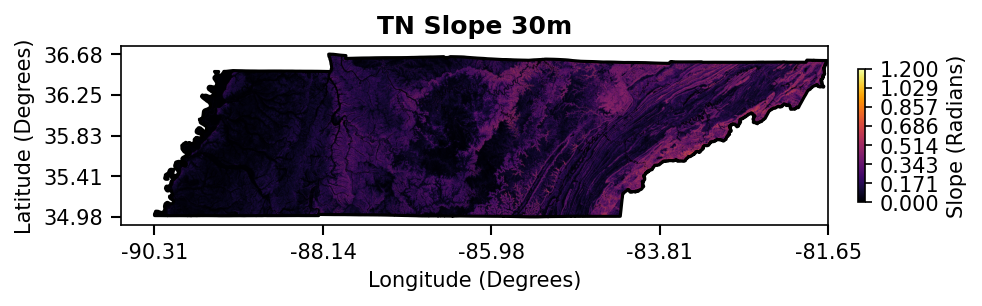

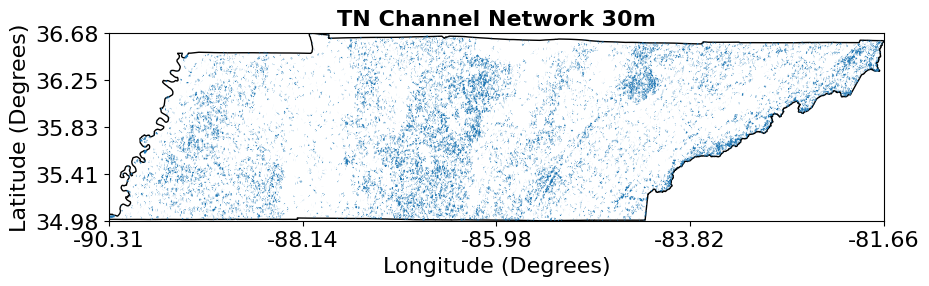

In [5]:
# Visualize the terrain parameters
geotiled.plot_raster(input_file='slope.tif', plot_title="TN Slope 30m", reproject_gcs=True, remove_nans=True, shapefiles=[region], downsample=5, zunit="Radian", xyunit="Degree", ztype="Slope")
geotiled.plot_shapefile(input_file='channel_network.shp', plot_title='TN Channel Network 30m', reproject_gcs=True, crop_to_shape=region)

## End of Demo